# <font style="font-family:roboto;color:#455e6c"> Validation of interatomic potentials </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> Machine Learning Modalities for Materials Science Workshop, Jožef Stefan Institute, Ljubljana </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 14 May 2024 </font>
</div>

In this notebook, we will run some validation calculations for interatomic potentials

## <font style="font-family:roboto;color:#455e6c"> Equation of State </font> 

We can try to calculate an EV curve with the potential we just created in the last session. We start by importing the necessary modules

In [1]:
%config IPCompleter.evaluation='unsafe'

In [2]:
from pyiron_atomistics import Project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

First we create a project, which points to the calculations we did

In [3]:
pr = Project('fitting')

Now we can get the potential we fitted to run with LAMMPS. For that, first we load the training job

In [4]:
job = pr.load('pacemaker_job')

In [5]:
pace_lammps_potential = job.get_lammps_potential()

In [6]:
pace_lammps_potential

,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /mnt/c/Use...",,ACE,pacemaker_job,[Al]


Now as we saw before, we can do an EV curve calculation for Al fcc

In [7]:
lammps_job = pr.create.job.Lammps("ref_Al", delete_existing_job=True)
lammps_job.structure = pr.create.structure.bulk("Al", cubic=True)
lammps_job.potential = pace_lammps_potential

In [8]:
murn = pr.create.job.Murnaghan("Al_murn_ace")
murn.ref_job = lammps_job

In [9]:
murn.run()

2024-05-07 14:14:02,132 - pyiron_log - WARNING - The job Al_murn_ace is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


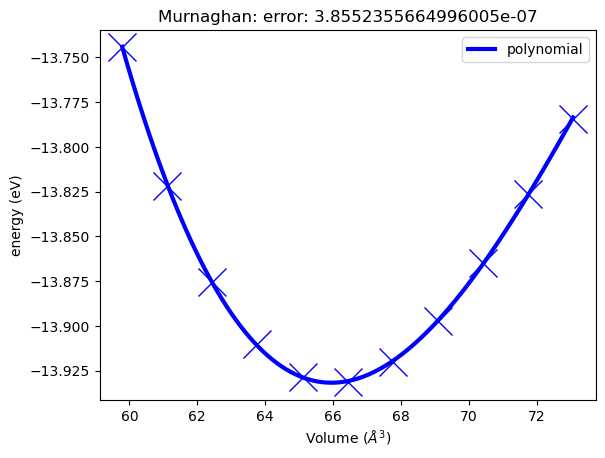

<Axes: title={'center': 'Murnaghan: error: 3.8552355664996005e-07'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [10]:
murn.plot()

We can now compare this with DFT results. The DFT results are provided in the form of a csv file

In [11]:
dft_ref = pd.read_csv('dft_ref.csv')

In [12]:
dft_ref.head()

,Unnamed: 0.1,Unnamed: 0,energy,number_of_atoms,volume,energy_per_atom,compound
0,22,886,-14.818128,4,14.835973,-3.433909,Alfcc
1,23,887,-14.893430,4,15.165661,-3.452735,Alfcc
2,24,888,-14.948596,4,15.495350,-3.466526,Alfcc
3,25,889,-14.985750,4,15.825038,-3.475815,Alfcc
4,26,890,-15.006807,4,16.154726,-3.481079,Alfcc


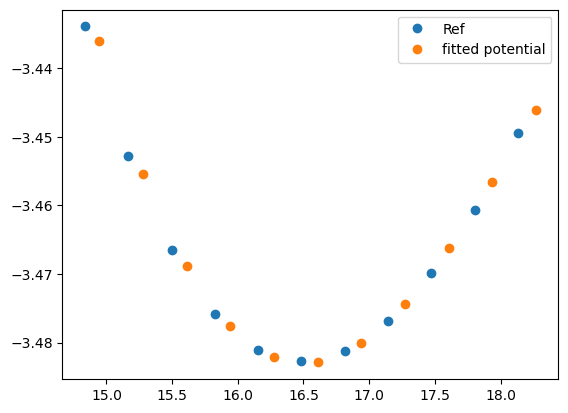

In [13]:
plt.plot(dft_ref['volume'], dft_ref['energy_per_atom'], 'o', label='Ref')
plt.plot(murn['output/volume']/len(murn.structure), murn['output/energy']/len(murn.structure), 'o', label='fitted potential')
plt.legend();

For the simple potential, we have quite nice agreement with the DFT data!

## <font style="font-family:roboto;color:#455e6c"> Phonons </font> 

Now we can get phonon density of states using Phonopy

In [16]:
job_ref = pr.create.job.Lammps('phonopy_ref')
job_ref.structure = murn.get_structure()
job_ref.potential = pace_lammps_potential
job_ref.calc_minimize()

phonopy_job = job_ref.create_job(pr.job_type.PhonopyJob, f"phonopy_job")
job_ref.calc_static()
phonopy_job.run()

The job phonopy_job was saved and received the ID: 437
The job elastic_ref_0 was saved and received the ID: 438


Text(0.5, 0, 'Frequency (THz)')

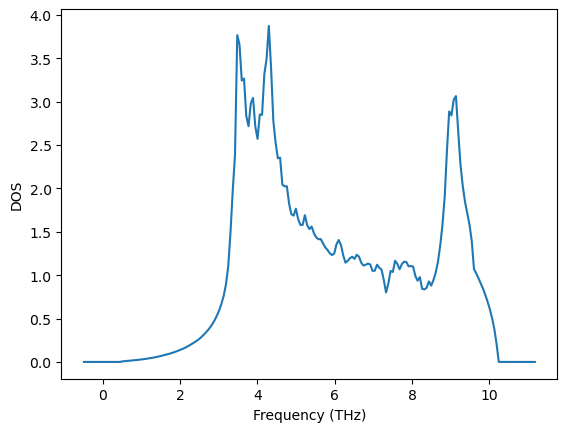

In [20]:
plt.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
                lw=1.5,)
plt.ylabel("DOS")
plt.xlabel("Frequency (THz)")

## <font style="font-family:roboto;color:#455e6c"> Thermodynamics </font> 

We can also calculate more complex properties for our potential, such as the melting temperature, or phase diagram itself. Since these calculations are more expensive, we will once again switch to an EAM potential.

But before that, a little bit about phase diagrams

### <font style="font-family:roboto;color:#455e6c"> A simple phase diagram </font> 

<img src="img/phase_dia_1.png" width="40%">

Phase diagrams provide a wealth of information such as: coexisting lines, melting temperature, phase stability, nucleation mechanism.

### <font style="font-family:roboto;color:#455e6c"> Calculation of phase diagrams: the essential ingredients </font> 

<img src="img/cimg4.png" width="50%">

Phase diagrams can be evaluated from free energy diagrams. The required input are:
- $G(P, T)$ for unary systems
- $G(x, T)$ for binary systems

To calculate this, we employ thermodynamic integration, in conjuction with a number of methodological improvements.

<div class="admonition note" name="html-admonition" style="background: #FFEDD1; padding: 10px">
<p class="title"><b>Theory behind free energy calculation </b></p>
Please see the end of this notebook, or  <a href="https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.5.103801">this publication</a> for a longer discussion on the theory and algorithms.
</div>

Start with creating a new project

In [26]:
pr = Project('thermodynamics') 

Due to our limited time, we will show the calculation of melting temperature, the end point on the phase diagram. We leverage a software tool for calculation of free energies, [calphy](https://calphy.org) along with pyiron for efficient and automated free energy calculations. For a detailed tutorial, see [here](https://workshop.pyiron.org/potentials-workshop-2022/phase_diagram/Intro.html).

### <font style="font-family:roboto;color:#455e6c"> Calculation of melting temperature </font> 

#### <font style="font-family:roboto;color:#455e6c"> Solid free energy </font> 

In [27]:
al_sol = pr.create.job.Calphy("Al_fcc", 
                              delete_aborted_job=True, 
                              delete_existing_job=True)

There are a number of input the job can take. We can gain some information about the job from the docstrings.

In [28]:
structure = pr.create.structure.ase.bulk('Al', cubic=True).repeat(3)

In [29]:
structure.plot3d()

NGLWidget()

In [30]:
al_sol.structure = structure

In [31]:
al_sol.potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'

In [32]:
al_sol.input.equilibration_control = 'berendsen'

In [33]:
al_sol.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=2500,
                     n_switching_steps=2500)

Before we actually run the calculation, let us discuss the various parameters. `temperature` keyword gives the temperature range over which the free energy is to be calculated. Since we provide `500`, the free energy is calculated at this temperature. `pressure` denotes the pressure of the calculation, we chose 0 in this case. Since we are using a solid FCC lattice, we set `reference_phase` to `"solid"`. This means that the Einstein crystal will be used as the reference system. Finally, we have `n_equilibration_steps` and `n_switching_steps`. `n_equilibration_steps` denotes the number of MD steps over which the system is equilibrated to the required temperature and pressure. `n_switching_steps` are the number of MD steps over which the system is continuously transformed between the given interatomic potential, and the reference Einstein crystal.

Now we can actually run the calculation

In [34]:
al_sol.run()

The job Al_fcc was saved and received the ID: 439
Job 439 is running!


#### <font style="font-family:roboto;color:#455e6c"> Liquid free energy </font> 

In [35]:
al_lqd = pr.create.job.Calphy("Al_lqd", delete_aborted_job=True)
al_lqd.structure = structure
al_lqd.potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'
al_lqd.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="liquid",
                     n_equilibration_steps=2500,
                     n_switching_steps=2500)
al_lqd.run()

The job Al_lqd was saved and received the ID: 440
Job 440 is running!


Finally, the results

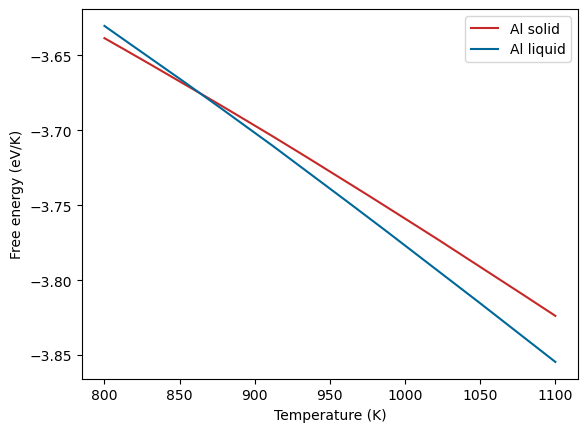

In [36]:
plt.plot(al_sol.output.temperature, al_sol.output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(al_lqd.output.temperature, al_lqd.output.energy_free,
        label="Al liquid", color='#006899')
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

We can see that calculated melting temperature, where the free energy of both solid and liquid phases are equal, is between 850-900 K. Note that we used really small system size, and switching times for these calculations, we would need approximately 1000 atoms, and more than 50 ps switching time to get accurate results.

---

### <font style="color:#455e6c" face="Helvetica" > Calculation of free energies: Thermodynamic integration </font>

<img src="img/fig1.png" width="1000">

- free energy of reference system are known: Einstein crystal, [Uhlenbeck-Ford model](https://doi.org/10.1063/1.4967775)
- the two systems are coupled by 
$$
H(\lambda) = \lambda H_f + (1-\lambda)\lambda H_i
$$
- Run calculations for each $\lambda$ and integrate 
$$
G_f = G_i + \int_{\lambda=0}^1 d\lambda \bigg \langle  \frac{\partial H(\lambda)}{\partial \lambda } \bigg \rangle
$$

To calculate $F$,

- for each phase
    - for each pressure
        - for each temperature
            - for each $\lambda$

If we choose 100 different $\lambda$ values; 100 calculations are needed for each temperature and pressure! 

**Dimensionality: (phase, $P$, $T$, $\lambda$)**

### <font style="color:#455e6c" face="Helvetica" > Speeding things up: Non-equilibrium calculations </font>

##### Non-Equilibrium Hamiltonian Interpolation

<img src="img/cimg5.png" width="600">

In this method:

- Discrete $\lambda$ parameter is replaced by a time dependent $\lambda(t)$
- Instead of running calculations at each $\lambda$, run a single, short, non-equilibrium calculation

$$
G_f = G_i + \int_{t_i}^{t_f} dt \frac{d\lambda (t)}{dt}  \frac{ H(\lambda)}{\partial \lambda }
$$

As discussed:
- the coupling parameter $\lambda$ earlier is replaced by a time dependent parameter
- The equation also no longer has an ensemble average  

These aspects makes it quite easy and fast to estimate this integral.

However:
- this equation holds when the switching betwen the system of interest and reference system is carried out infinitely slowly
- Practically, this is not not possible. 

Therefore we can write:

$$
\Delta G = W_{rev} = W_s - E_d
$$

$$
W_s = \int_{t_i}^{t_f} dt \frac{d\lambda (t)}{dt}  \frac{ H(\lambda)}{\partial \lambda }
$$

- $E_d$ is the energy dissipation
- $E_d \to 0$ when $t_f-t_i \to \infty$

So far, so good, but how is this useful?

- Instead of a single transformation from system of interest to reference, we switch back too
- These are called forward $(i \to f)$ and backward $(f \to i)$ switching
- $t_f - t_i = t_{sw}$ is the switching time in each direction
- If $t_{sw}$ is long enough, $E_d^{i \to f} = E_d^{f \to i}$
- and $\Delta G = \frac{1}{2} (W_s^{i \to f} - W_s^{f \to i})$

Now, we have all the components required for actual calculations.

We have also managed to successfully reduce the dimensionality

- for each phase
    - for each pressure
        - for each temperature
            - ~~for each $\lambda$~~

**Dimensionality: (phase, $P$, $T$)**


So, how do we calculate the free energy of a system modelled with a given interatomic potential?

### <font style="color:#455e6c" face="Helvetica" > Free energy for solids </font>

#### Task: Find free energy of Al in FCC lattice at 500 K and 0 pressure

1. Create an Al FCC lattice
2. Choose an interatomic potential
3. Run MD calculations at 500 K and 0 pressure to equilibrate the system
4. Introduce the reference system
5. Switch....
6. .....

Steps 1-3 should be fairly easy, we saw this in the last days and also in the first session. But how do we introduce a reference system?

- A reference system is simply one for which the free energy is analytically known ($G_i$)
- We calculate the free energy difference between this and the system of interest.

In case of solids, a good choice of a reference system is the Einstein crystal. An Einstein crystal is a set of independent harmonic oscillators attached to the lattice positions. 


The free energy of the Einstein crystal is:

$$
F_E = 3 k_B T \sum_{i} ln \bigg ( \frac{\hbar \omega_i}{k_B T} \bigg )
$$

We need to calculate:

- $\omega$
- A common way is $$  \frac{1}{2} k_i \langle (\Delta \pmb{r}_i)^2 \rangle = \frac{3}{2} k_\mathrm{B} T $$
- $\langle (\Delta \pmb{r}_i)^2 \rangle$ is the mean squared displacement.

Now that we know about the reference system, let's update our pseudo workflow:

1. Create an Al fcc lattice
2. Choose an interatomic potential
3. Run MD calculations at 500 K and 0 pressure to equilibrate the system
4. Calculate the mean squared displacement, therefore spring constants
5. Switch system of interest to reference system
6. Equilibrate the system
7. Switch back to system of interest
8. Find the work done
9. Add to the free energy of the Einstein crystal

As you can see, there are a number of steps that need to be done. This is where **calphy** and **pyiron** come in. These tools automatise all of the above steps and makes it easy to perform these calculations.

### <font style="color:#455e6c" face="Helvetica" > Free energy as function of temperature </font>

<img src="img/cimg6.png" width="600">

Gibb's free energy via reversible scaling at a constant pressure is given by,

$ G(N,P,T_f) = G(N,P,T_i) + \dfrac{3}{3}Nk_BT_f\ln{\dfrac{T_f}{T_i}} + \dfrac{T_f}{T_i}\Delta G $,

Therefore, $G(N,P,T_f)$ can be computed from $G(N,P,T_i)$ via the free energy difference $\Delta G$. 

Here, $\Delta G = \dfrac{1}{2}[W_{if}-W_{fi}$] --- (2)

The reversible work is related to the internal energy $U$ by,
$W = \int_{1}^{\lambda_f}<U> \,d\lambda$ --- (3)

Using MD $W$ can be computed as:
- equilibrate for time $t_{eq}$ in NPT ensemble
- switch $\lambda$ : $1->\dfrac{T_f}{T_i}$ over time $t_{sw}$
- calculate work $W_{if}$ from (3)
- equilibrate for time $t_{eq}$ in NPT ensemble
- switch $\lambda$ : $\dfrac{T_f}{T_i}->1$ over time $t_{sw}$
- calculate work $W_{fi}$ from (3).

### <font style="color:#455e6c" face="Helvetica" > Free energy for liquids </font>

**How is the liquid prepared in this calculation?**

- Start from the given structure
- This structure is heated until it melts.
- Melting of the structure is automatically detected by calphy
- Once melted, it is equilibrated to the required temperature and pressure.

**What about the reference system for liquid?**

The reference system for the Liquid structure is also different. In this case, the Uhlenbeck-Ford system is used as the reference system for liquid.

The Uhlenbeck-Ford model is described by,

$$
E = - \epsilon \log(1-\exp(-r^2/\sigma^2))
$$

where,

$$
\epsilon = p k_B T
$$

$\epsilon$ and $\sigma$ are energy and length scales, respectively.

It is purely repulsive liquid model which does not undergo any phase transformations.

### <font style="color:#455e6c" face="Helvetica" > Comparison of melting temperature methods </font>

<img src="img/tm_methods.png" width="900">

### <font style="color:#455e6c" face="Helvetica" > Further reading </font>
- [Menon et al. "From electrons to phase diagrams with classical and machine learning potentials: automated workflows for materials science with pyiron"](https://arxiv.org/pdf/2403.05724.pdf)
- [Menon, Sarath, Yury Lysogorskiy, Jutta Rogal, and Ralf Drautz. “Automated Free-Energy Calculation from Atomistic Simulations.” Physical Review Materials 5, no. 10 (October 11, 2021): 103801.](https://doi.org/10.1103/PhysRevMaterials.5.103801).
- [Freitas, Rodrigo, Mark Asta, and Maurice de Koning. “Nonequilibrium Free-Energy Calculation of Solids Using LAMMPS.” Computational Materials Science 112 (February 2016): 333–41.](https://doi.org/10.1016/j.commatsci.2015.10.050).
- [Paula Leite, Rodolfo, and Maurice de Koning. “Nonequilibrium Free-Energy Calculations of Fluids Using LAMMPS.” Computational Materials Science 159 (March 2019): 316–26.](https://doi.org/10.1016/j.commatsci.2018.12.029).
- [Koning, Maurice de, A. Antonelli, and Sidney Yip. “Optimized Free-Energy Evaluation Using a Single Reversible-Scaling Simulation.” Physical Review Letters 83, no. 20 (November 15, 1999): 3973–77.](https://doi.org/10.1103/PhysRevLett.83.3973).
- [Paula Leite, Rodolfo, Rodrigo Freitas, Rodolfo Azevedo, and Maurice de Koning. “The Uhlenbeck-Ford Model: Exact Virial Coefficients and Application as a Reference System in Fluid-Phase Free-Energy Calculations.” The Journal of Chemical Physics 145, no. 19 (November 21, 2016): 194101.](https://doi.org/10.1063/1.4967775).



### <font style="font-family:roboto;color:#455e6c"> Software used in this notebook </font>  

- [calphy](https://calphy.org)
- [pyiron_atomistics](https://github.com/pyiron/pyiron_atomistics)
- [LAMMPS](https://www.lammps.org/)